# Assignment 1  
46110 Basic Aerodynamics

In [1]:
# Modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

### A)
Determine $\dfrac{m_1}{c}$ and $\dfrac{m_2}{c}$ for the Joukowski airfoil with relative (to chord) thicknesses of 10%, 20% and 30% and maximum camber 0% and 10%.  
Also try to do this with the linearized approach from the book.

Numerical approach:  
Transformation: $z = \zeta+\dfrac{c^2}{\zeta}$  


In [2]:
# Parameters
alphad = 0 # angle of attack (for D and E)
m1oc = 0. # m1/c 
m2oc = 0. # m2/c
R = 1. # Radius of transformation circle

theta_str = str(alphad)+'°'
alpha = alphad*np.pi/180
c = R/np.sqrt(m2oc**2+(1+m1oc)**2)
c2 = c**2
chord = 4*c
m1 = m1oc*c
m2 = m2oc*c
s = -m1 + 1j*m2

# Targets
toc = np.array([0.1, 0.2, 0.3]) # max relative thickness
hoc = np.array([0, 0.1]) # max relative camber

Max thickness: $\dfrac{t}{c}\bigg) _{max}$  
Max camber: $\dfrac{h}{c}\bigg) _{max}$  
Just take thickness as be the difference in y-values so $t=y_u-y_l$  
With the camber line: $h = \dfrac{y_y+y_l}{2}$

In [126]:
N = 2000 # EVEN number
x_start, x_end = -5.0, 5.0        # boundaries for x-dir.
y_start, y_end = -5.0, 5.0        # boundaries for y-dir.
x_ar = np.linspace(x_start, x_end, N)    #
y_ar = np.linspace(y_start, y_end, N)
x, y = np.meshgrid(x_ar,y_ar)               # meshes grid

# Complex mesh plane
z = x+1j*y

# Exclusion of points inside circle
for i in range(N):
    for j in range(N):
        if abs(z[i,j])<= (R-5e-3):
            z[i,j] = complex(float('nan'),float('nan'))
#z = z[None,:,:]

In [127]:
M1 = 400
M2 = 400
n_tests = int(M1*M2) # Number of tests

# Various values for m1/c and m2/c
m1oc = np.linspace(0, 0.4, M1) 
m2oc = np.linspace(0, 0.4, M2)

## Testing the different values

# Empty array to fill in
r_t = np.array([]) # max relative thickness
r_c = np.array([]) # max relative camber
r_m1oc = np.array([]) # m1oc value
r_m2oc = np.array([]) # m2oc value

# Actual testing
for i in range(M1):
    for j in range(M2):
        c = R/np.sqrt(m2oc[j]**2+(1+m1oc[i])**2)
        c2 = c**2
        chord = 4*c
        m1 = m1oc[i]*c
        m2 = m2oc[j]*c
        s = -m1 + 1j*m2 # center of circle in zeta
        J = z+c2/z # Joukowski transformation of all points

        angle = np.linspace(0, 2*np.pi, N) 
        
        # coord. for circle periphery
        z_circle = R*(np.cos(angle)+1j*np.sin(angle)) + s
        
        # coord. for airfoil periphery (J-transform of circle)
        z_airfoil = z_circle+c2/z_circle
        
        # Upper part of airfoil (from right to left)
        za_upper = z_airfoil[:(int(N/2)-1)]
        za_upper = za_upper[::-1] # Reversing array order
        
        # Lower part of airfoil (left to right)
        za_lower = z_airfoil[(int(N/2)+1):]
        
        # Interpolation functions for upper and lower airfoil curve
        fu = interpolate.interp1d(za_upper.real,za_upper.imag, kind='cubic')
        fl = interpolate.interp1d(za_lower.real,za_lower.imag, kind='cubic')
        
        # Limit values for interpolation.
        # Leading and trailing edge removed to avoid errors.
        lim1 = np.min( z_airfoil.real )*0.95
        lim2 = np.max( z_airfoil.real )*0.95
        # Evaluation points
        span = np.linspace(lim1,lim2,200)
        
        
        # Finding max relative thickness
        max_t = np.max( (fu(span) - fl(span))/chord )
        max_camber = np.max( (fu(span)+fl(span))/2 )
        
        # Save result
        r_t = np.append(r_t, max_t)
        r_c = np.append(r_c, max_camber)
        r_m1oc = np.append(r_m1oc, m1oc[i])
        r_m2oc = np.append(r_m2oc, m2oc[j])

ValueError: A value in x_new is below the interpolation range.

In [130]:
np.savetxt('maxRelThickness.txt',r_t)
np.savetxt('maxRelCamber.txt',r_c)
np.savetxt('m1oc.txt',r_m1oc)
np.savetxt('m2oc.txt',r_m2oc)

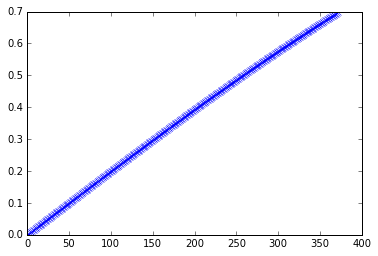

In [131]:
plt.plot(r_c,'x')

In [117]:
a = np.array([])

In [120]:
a = np.append(a,3)

In [121]:
a

array([ 1.,  2.,  3.])

In [110]:
for i in range(M1):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### A) Results

$t_{rel, max}$: 0.10005 - $m/c$= (0.081, 0.200)  
$t_{rel, max}$: 0.09993 - $m/c$= (0.083, 0.044)  
$t_{rel, max}$: 0.10009 - $m/c$= (0.083, 0.067)  
  


In [84]:
a = np.array([])

In [85]:
a = np.append(np.array([1,2,3]),a,axis=1)

IndexError: axis 1 out of bounds [0, 1)

In [83]:
a

array([ 1.,  2.,  3.,  1.,  2.,  3.])

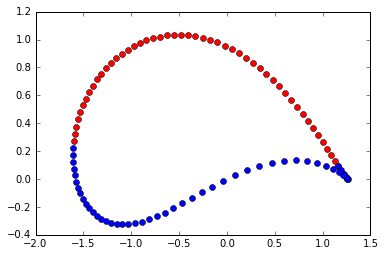

In [11]:
plt.plot(za_upper.real,za_upper.imag,'ro')
plt.plot(za_lower.real,za_lower.imag,'bo')

In [ ]:
plt.plot(z_circle.real, z_circle.imag)

In [ ]:
plt.plot(za_upper.real-za_lower.real)

In [ ]:
plt.plot(z_airfoil.real, z_airfoil.imag,'o')

In [ ]:
        if 0.0990< max_trel < 0.1010:
            # Print and plot if within tolerance.
            ind = np.argmax((fu(span) - fl(span))/chord) # index in span
            print('trel: {0:.5f} - m/c= ({1:.3f}, {2:.3f})'.format(max_trel, m1oc[i], m2oc[j]))
            plt.plot(span,fu(span),'.-b')
            plt.plot(span,fl(span),'.-r')
            plt.plot(span[ind],fu(span[ind]),'ro',ms=5)
            plt.plot(span[ind],fl(span[ind]),'bo',ms=5)